In [1]:
import csgm
import image_utils
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import skimage
import tensorflow_hub as hub
import warnings
import pretrained_models
warnings.filterwarnings('ignore')

W0328 14:09:29.857167 140284299699968 __init__.py:56] Some hub symbols are not available because TensorFlow version is less than 1.14


In [2]:
g1, tensors = csgm.create_graph()

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0327 00:37:33.959810 139994702214912 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


In [2]:
orig,img = image_utils.transform_img_fast('./ILSVRC2012_val/ILSVRC2012_val_00050000.JPEG')
print(img.shape)
segments = skimage.segmentation.quickshift(img, kernel_size=8, max_dist=200, ratio=0.2)

(256, 256, 3)


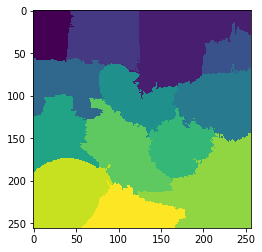

In [4]:
plt.imshow(segments)

In [5]:
exp = {}
exp['feature'] = [8,6,5,10]

In [6]:
mask_new, mask = image_utils.create_mask(img,segments,exp)

[8, 6, 5, 10]


In [7]:
target = img * mask_new

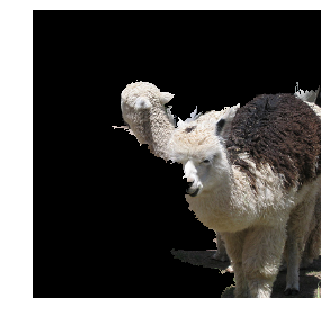

In [8]:
image_utils.ShowImageNoAxis(target)

In [9]:
num_pixels = float(np.sum(mask_new == 1))

## Training

In [10]:
config=tf.ConfigProto(log_device_placement=True)
config.gpu_options.allow_growth = True
sess = tf.Session(config=config, graph=g1)

In [11]:
n_iterations = 1000

In [12]:
with g1.as_default():
    init = tf.global_variables_initializer()
    sess.run(init)
    z = sess.run(tensors['z'])

In [13]:
first_z = z

In [14]:
with g1.as_default():
    _, sample,diff,anchored = sess.run([tensors['assign_op'],tensors['sample'],tensors['diff_z'],tensors['anchored']], feed_dict = {tensors['target']:target, 
                                                           tensors['filter']: mask_new, 
                                                           tensors['class_']: [355],
                                                           tensors['init_z']: z})

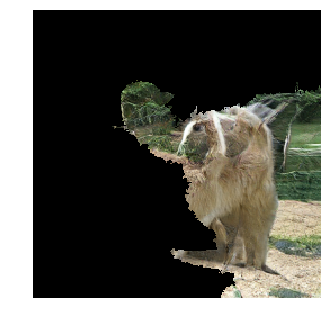

In [15]:
image_utils.ShowImageNoAxis(anchored)

In [19]:
with g1.as_default():
    for i in range(n_iterations):
        class_ = 355
        _,loss,_,z = sess.run([tensors['assign_op'],tensors['loss'],tensors['min_'],tensors['z']], feed_dict = {tensors['target']:target, 
                                                                           tensors['filter']: mask_new, 
                                                                           tensors['class_']: [class_],
                                                                           tensors['init_z']: z,
                                                                           tensors['num_pixels']: [num_pixels]})
        if i % 50 == 0:
            print(i, loss)

0 [0.16394694]
50 [0.14408347]
100 [0.13364322]
150 [0.12658387]
200 [0.12020753]
250 [0.11539955]
300 [0.11244088]
350 [0.11028734]
400 [0.10832718]
450 [0.10647459]
500 [0.10471889]
550 [0.10304551]
600 [0.10134254]
650 [0.09937273]
700 [0.09778664]
750 [0.09615187]
800 [0.09466624]
850 [0.09335742]
900 [0.09216706]
950 [0.09096608]


KeyboardInterrupt: 

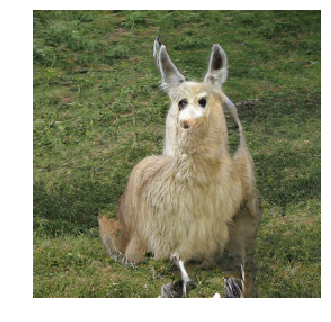

In [20]:
with g1.as_default():
    _,sample,anchored = sess.run([tensors['assign_op'],tensors['sample'],tensors['anchored']], feed_dict = {tensors['target']:target, 
                                                       tensors['filter']: mask_new, 
                                                       tensors['class_']: [class_],
                                                       tensors['init_z']: z})
    image_utils.ShowImageNoAxis(sample)

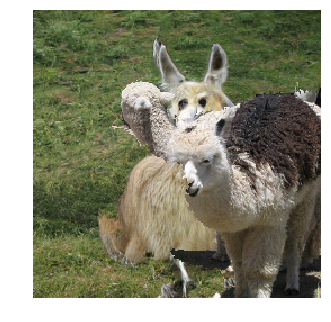

In [21]:
image_utils.ShowImageNoAxis(sample*(1-mask_new) + target)

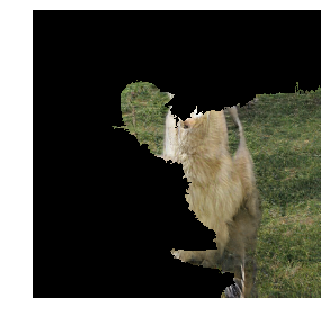

In [22]:
image_utils.ShowImageNoAxis(anchored)

In [22]:
with tf.device('/cpu:0'):
    g2, inception_tensors = pretrained_models.inceptionv3()

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0327 00:12:45.739817 140267527890688 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


In [7]:
sess = tf.Session(graph=g2)
with g2.as_default():
    init = tf.global_variables_initializer()
    sess.run(init)

In [9]:
with g2.as_default():
    pred, prob, processed = sess.run([inception_tensors['prediction'], inception_tensors['proba_'], inception_tensors['processed']], feed_dict={inception_tensors['input_'] : orig})

In [10]:
prob.argsort()

array([[488, 201,  66, ...,  10, 349, 356]])

In [11]:
pred

array([356])

In [12]:
prob = prob.reshape(-1)

In [13]:
prob.shape

(1001,)

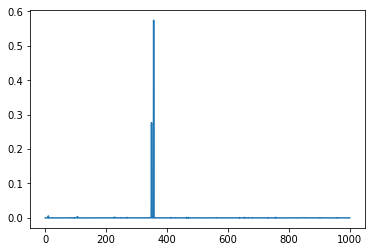

In [14]:
plt.plot(range(1001), prob)

In [37]:
logits = inception(tf.reshape(tf.image.resize_images(img,(299,299)),(-1,299,299,3)))

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0326 14:27:27.326915 139919959631616 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


In [42]:
print(tf.argmax(logits,axis=1)

TensorShape([Dimension(1), Dimension(1001)])